In [1]:
# Importa os arquivos necessários
import matplotlib.pyplot as plt
import timeit
import keras.layers as kl
import numpy as np
import pyaiutils
import matplotlib.colors as colors
import itertools

from keras import Sequential
from keras.optimizers import RMSprop, Adam, Adamax, Adadelta, SGD
from keras.datasets import cifar10
from keras.models import Model
from keras.utils import to_categorical, plot_model
from collections import Counter
from keras.backend import clear_session
from sklearn.model_selection import KFold

In [2]:
# Carrega (ou baixa, se for necessário) o dataset do Cifar 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

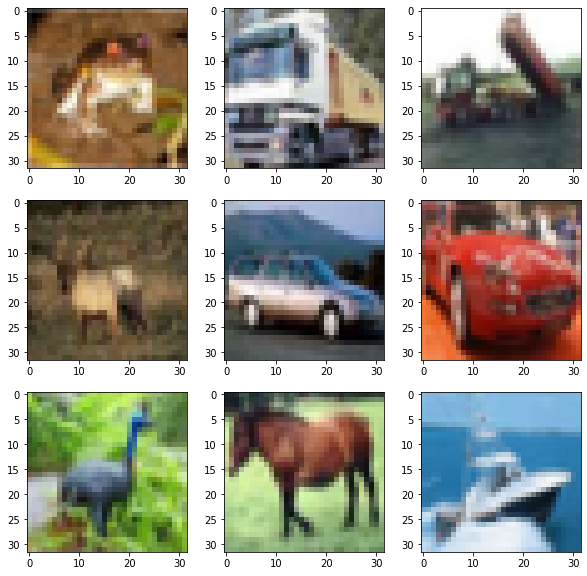

In [3]:
# Apresenta 9 imagens do dataset em escala de cinza
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [4]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

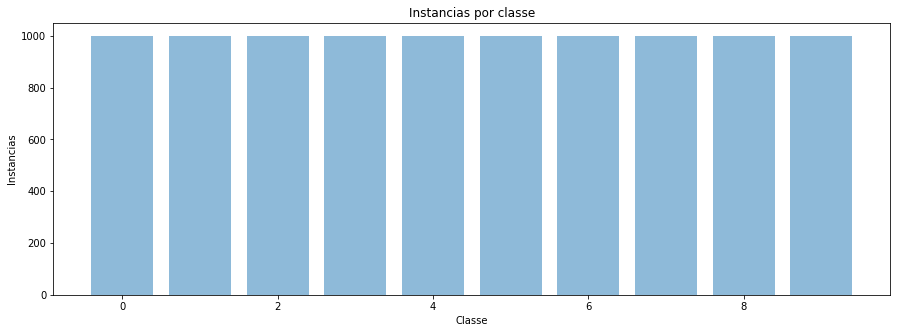

In [5]:
# Gráfico de instâncias por classe
plt.figure(figsize=(15,5))
plt.bar(Counter(y_test).keys(), Counter(y_test).values(), align='center', alpha=0.5)
plt.ylabel('Instancias')
plt.xlabel('Classe')
plt.title('Instancias por classe')
plt.show()

In [6]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000,)


In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [8]:
num_classes = len(Counter(y_test))

In [9]:
# Estou convertendo o vetor objetivo para uma matriz de classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
# Criando o modelo a ser utilizado
def get_model(nb_classes = 10, input_shape = (784,), summary=0):
    clear_session()

    # Iniciando o modelo de rede neural MLP
    model = Sequential()
    model.add(kl.Input(input_shape))
    model.add(kl.Conv2D(45, (5,5)))
    model.add(kl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(kl.Conv2D(30, (3,3)))
    model.add(kl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # model.add(kl.Conv2D(15, (2,2)))
    model.add(kl.Flatten())
    model.add(kl.Dense(180, activation='relu'))
    model.add(kl.Dropout(0.2))
    model.add(kl.Dense(90, activation='relu'))
    model.add(kl.Dropout(0.2))
    model.add(kl.Dense(30, activation='relu'))
    model.add(kl.Dense(nb_classes, activation='softmax'))

    # Compilando o modelo
    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

    if(summary):
        # Apresentando a estrutura do modelo
        model.summary()

    
    # Retornando o modelo
    return model

In [11]:
x_test.shape[1:]

(32, 32, 3)

In [12]:
model = get_model(num_classes, x_test.shape[1:], 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 45)        3420      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 45)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 30)        12180     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1080)              0         
_________________________________________________________________
dense (Dense)                (None, 180)               194580    
_________________________________________________________________
dropout (Dropout)            (None, 180)               0

In [13]:
# Quantidade de épocas
epochs = 20
# Batch size para treinamento
bs = 200

# Computando o tempo para treinar (início)
start = timeit.default_timer()

# Treinando o modelo, e armazenando o resultado do treinamento em uma variável
hist = model.fit(x_train, y_train,
                 epochs = epochs,
                 batch_size = bs,
                 validation_split=0.50,
                 verbose=1)

# Computando o tempo para treinar (fim)
stop = timeit.default_timer()

# Apresentando o tempo de treinamento
print('Tempo: ', stop - start)  

Epoch 1/20
125/125 [==============================] - 20s 162ms/step - loss: 2.0209 - accuracy: 0.2642 - val_loss: 1.7067 - val_accuracy: 0.3890
Epoch 2/20
125/125 [==============================] - 20s 156ms/step - loss: 1.6613 - accuracy: 0.4035 - val_loss: 1.6817 - val_accuracy: 0.4198
Epoch 3/20
125/125 [==============================] - 20s 158ms/step - loss: 1.5094 - accuracy: 0.4606 - val_loss: 1.4134 - val_accuracy: 0.4963
Epoch 4/20
125/125 [==============================] - 19s 155ms/step - loss: 1.3973 - accuracy: 0.5038 - val_loss: 1.3622 - val_accuracy: 0.5142
Epoch 5/20
125/125 [==============================] - 19s 153ms/step - loss: 1.2961 - accuracy: 0.5407 - val_loss: 1.2414 - val_accuracy: 0.5604
Epoch 6/20
125/125 [==============================] - 19s 153ms/step - loss: 1.2309 - accuracy: 0.5654 - val_loss: 1.2787 - val_accuracy: 0.5517
Epoch 7/20
125/125 [==============================] - 19s 152ms/step - loss: 1.1540 - accuracy: 0.5931 - val_loss: 1.1864 - val_ac

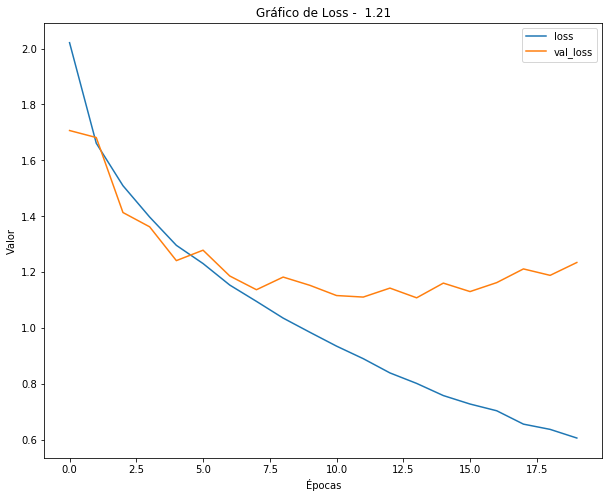

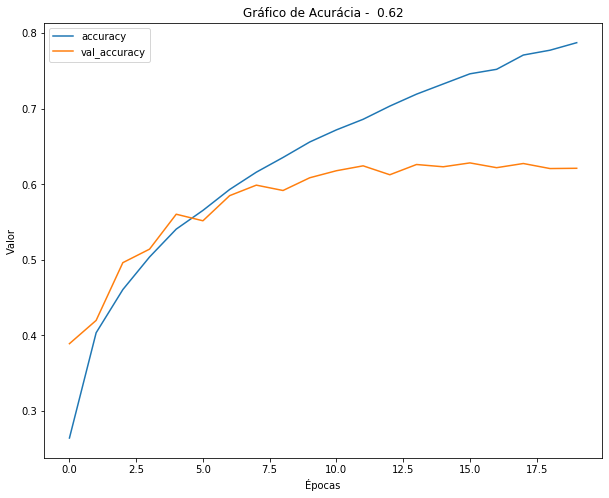

In [14]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)

# Gráfico de loss
plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Loss - {scores[0]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

# Gráfico de acurácia
plt.figure(figsize=(10,8))
plt.title(f"Gráfico de Acurácia - {scores[1]: .2f}")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.plot(hist.history['accuracy'], label="accuracy")
plt.plot(hist.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [15]:
predicted = model.predict(x_test)

In [16]:
print(predicted.shape)
print(y_test.shape)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predicted, axis=1)

(10000, 10)
(10000, 10)


In [17]:
pyaiutils.get_metrics(y_true, y_pred)

,Classes,F1-score,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,0,0.68,0.84,0.49,0.65,0.71,0.96,0.93
1,1,0.74,0.86,0.57,0.73,0.76,0.97,0.95
2,2,0.49,0.71,0.30,0.53,0.46,0.95,0.90
3,3,0.45,0.70,0.25,0.43,0.46,0.93,0.89
4,4,0.57,0.76,0.37,0.58,0.57,0.95,0.92
5,5,0.51,0.73,0.31,0.52,0.51,0.95,0.90
6,6,0.65,0.76,0.49,0.84,0.52,0.99,0.94
7,7,0.68,0.85,0.49,0.62,0.75,0.95,0.93
8,8,0.76,0.87,0.60,0.74,0.78,0.97,0.95
9,9,0.68,0.83,0.49,0.65,0.71,0.96,0.93


# Como são calculadas as métricas para cada classe?

Vamos considerar a seguinte tabela como exemplo

![Imagem](assets/images/example.png)

Fonte: https://www.researchgate.net/post/Can_someone_help_me_to_calculate_accuracy_sensitivity_of_a_66_confusion_matrix

## 1. Primeiro passo é saber quantas classes temos:
classes = [N, L, R, A, P, V]

## 2. Para cada classe, teremos que obter os TP, TN, FP, FN, e realizamos os cálculos como na imagem a seguir:

### Então, para a classe N

TP 1971

TN 9501

FP 37

FN 29

![Imagem](assets/images/class_N.png)

Acc 99.43%

precision=TP / (TP + FP) 98.16%

sensitivity = TP / (TP + FN) 98.55%

specificity = TN / (FP + TN) 99.61%

F-score = 2*TP /(2*TP + FP + FN) 98.35%


### Para a classe L

TP 1940

TN 9532

FP 83

FN 60

![Imagem](assets/images/class_L.png)

Acc 98.77%

precision=TP / (TP + FP) 95.90%

sensitivity = TP / (TP + FN) 97.00%

specificity = TN / (FP + TN) 99.14%

F-score = 2*TP /(2*TP + FP + FN) 96.45%

### Para a classe R

TP 1891

TN 9581

FP 195

FN 109


Acc 97.42%

precision=TP / (TP + FP) 90.65%

sensitivity = TP / (TP + FN) 94.55%

specificity = TN / (FP + TN) 98.01%

F-score = 2*TP /(2*TP + FP + FN) 92.56%


### Para a classe A

TP 1786

TN 9686

FP 137

FN 214

Acc 97.03%

precision=TP / (TP + FP) 92.88%

sensitivity = TP / (TP + FN) 89.30%

specificity = TN / (FP + TN) 98.61%

F-score = 2*TP /(2*TP + FP + FN) 91.05%


### Para a classe P

TP 1958

TN 9514

FP 36

FN 42

Acc 99.32%

precision=TP / (TP + FP) 98.19%

sensitivity = TP / (TP + FN) 97.90%

specificity = TN / (FP + TN) 99.62%

F-score = 2*TP /(2*TP + FP + FN) 98.05%


### Para a classe V

TP 1926

TN 9546

FP 40

FN 74

Acc 99.02%

precision=TP / (TP + FP) 97.97%

sensitivity = TP / (TP + FN) 96.30%

specificity = TN / (FP + TN) 99.58%

F-score = 2*TP /(2*TP + FP + FN) 97.13%


## Média de acurácia para todas as classes 98.50%

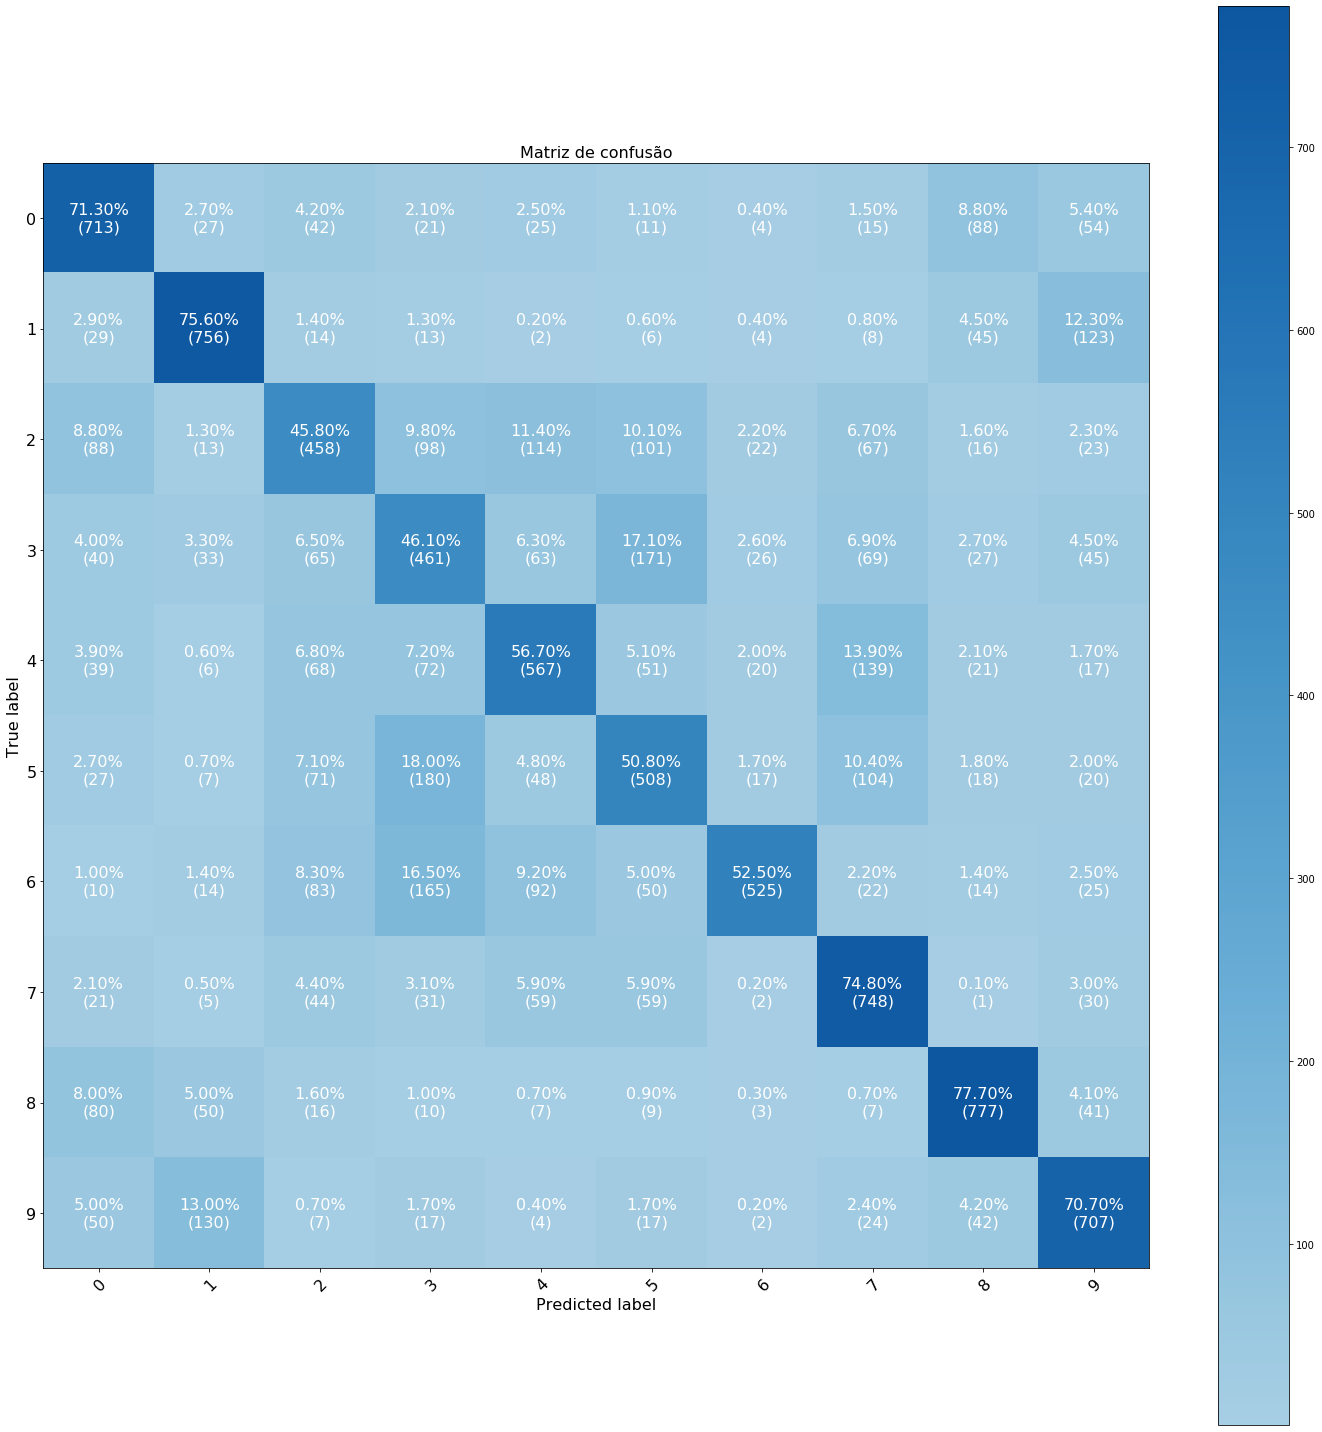

None

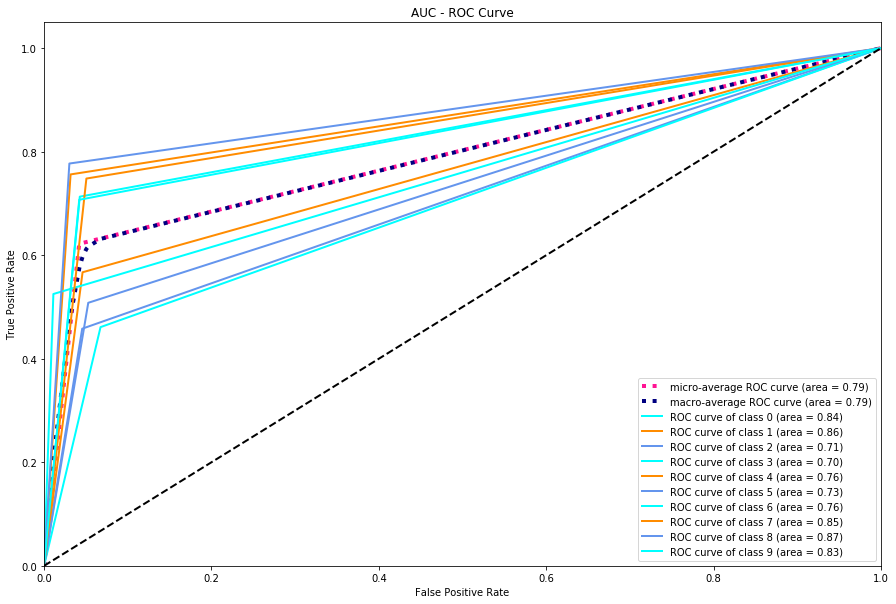

None

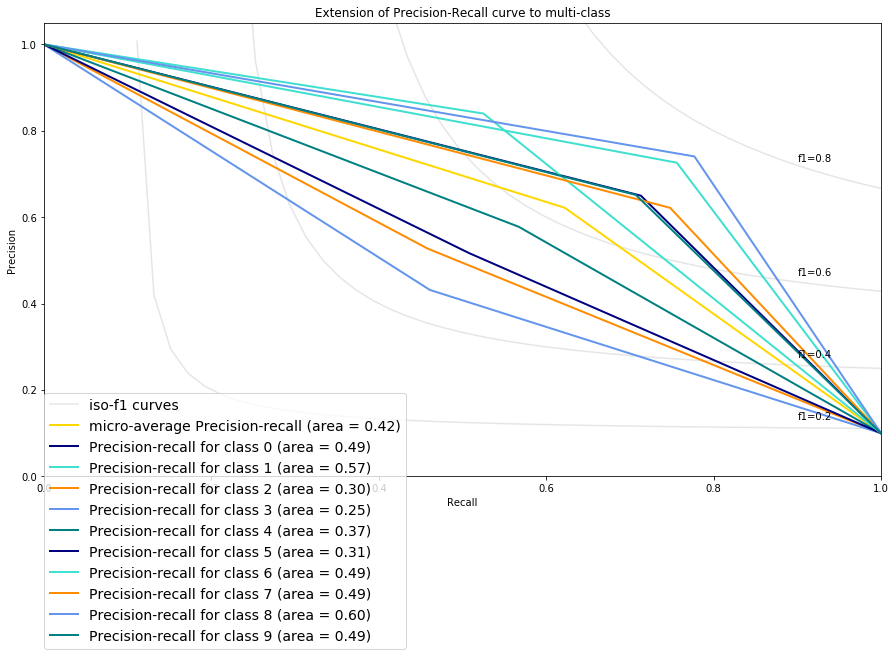

None

In [25]:
# Para apresentar os gráficos, podemos chamar as funções de forma individual, sendo:
class_names = np.unique(np.array(y_pred))

# 1. Matriz de confusão
# pyaiutils.plot_confusion_matrix(y_true, y_pred, visualize=True, normalize=True, class_names=class_names)

# 2. AUC Roc
# pyaiutils.plot_auc_roc_multi_class(y_true, y_pred, class_names=class_names)

# 3. AUC Precision-Recall
# pyaiutils.plot_prc_auc_multiclass(y_true, y_pred, class_names=class_names)

# 4. Ou podemos realizar a plotagem de todos os gráficos de uma só vez
pyaiutils.plot_graphics(y_true, y_pred)